In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
%%time
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')

numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh.head()

A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool&less', 'College&more'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])

A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups.sum(axis=0)

CPU times: user 88.9 ms, sys: 41.6 ms, total: 131 ms
Wall time: 129 ms


young                 22792
middle                16881
old                    9858
HighSchool&less       22584
College&more          26947
Male                  33174
Female                16357
White                 42441
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      471
Other                   406
Black                  4694
always_on             49531
dtype: int64

In [3]:
%%time
from bilevel.Groupwise_seedruns import Groupwise_over_seeds
plot_ob = Groupwise_over_seeds(df_adult_mm_oh, 'income', A_t_adult_groups)
plot_ob.build_all_seeds()
plot_ob.build_df_res()

100%|██████████| 49531/49531 [00:19<00:00, 2580.04it/s]


CPU times: user 28min 50s, sys: 55.7 s, total: 29min 45s
Wall time: 3min 43s


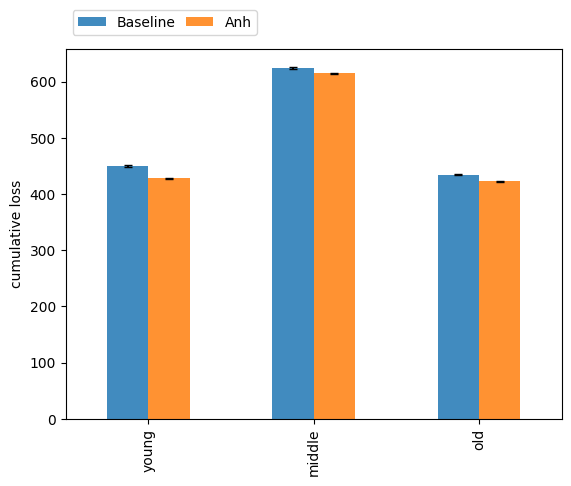

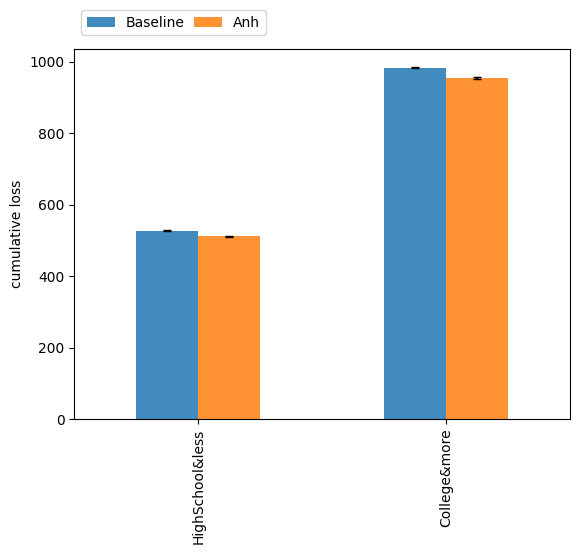

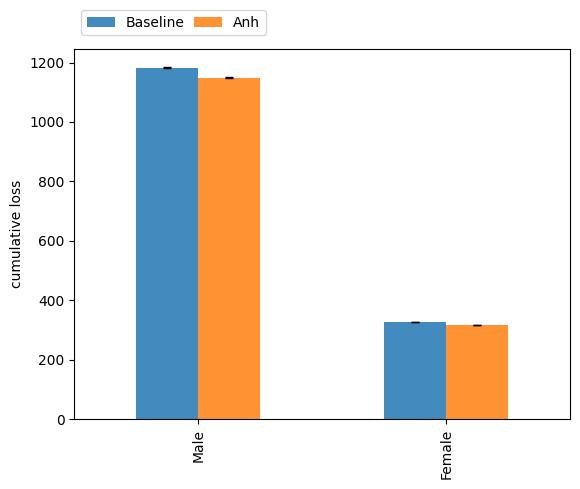

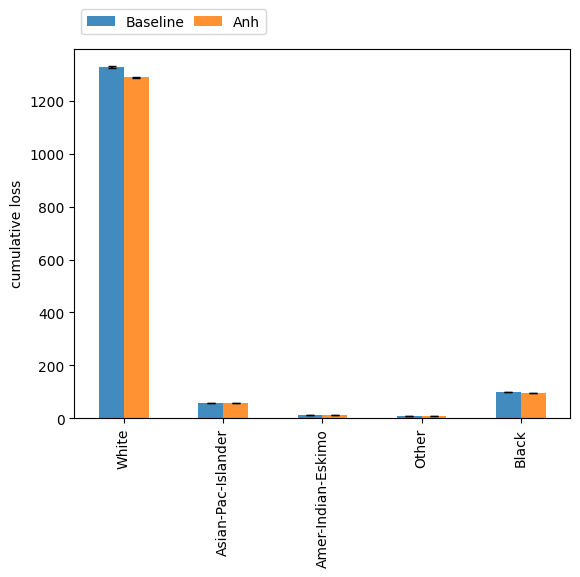

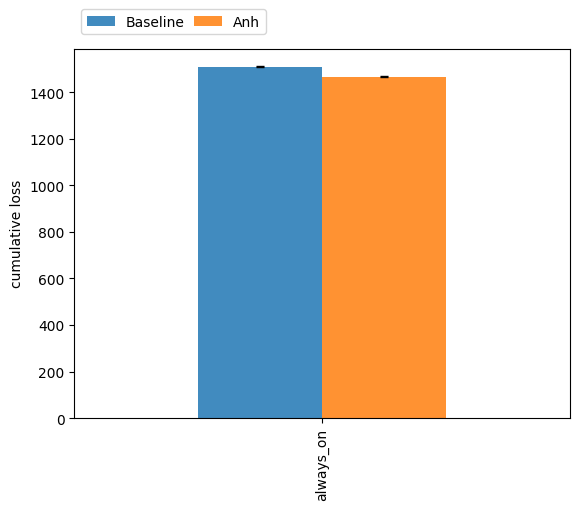

In [4]:
subgroups_list = [['young', 'middle', 'old'], ['HighSchool&less', 'College&more'], ['Male', 'Female'],
['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'], ['always_on']]
plot_ob.plot_subgroups(subgroups_list)

In [5]:
pd.concat([plot_ob.df_base_meansd, plot_ob.df_Anh_meansd], axis=1)

,mean_base,std_base,mean_Anh,std_Anh
young,450.168510,1.276885,428.277620,0.847336
middle,624.831559,1.705613,614.592733,1.611411
old,434.394247,1.149837,422.683228,1.412409
HighSchool&less,526.493605,1.094041,511.408555,1.089702
College&more,982.900711,1.998353,954.145025,1.724671
Male,1182.621030,2.315097,1149.271282,1.681161
Female,326.773286,0.503465,316.282298,0.891207
White,1326.996324,2.398741,1287.520499,2.090025
Asian-Pac-Islander,59.481154,0.288898,58.263756,0.465740
Amer-Indian-Eskimo,12.380835,0.144627,12.317055,0.236884


In [6]:
%%time
plot_ob.build_regret_curve()

CPU times: user 8min 49s, sys: 15.4 s, total: 9min 4s
Wall time: 1min 8s


In [7]:
import pickle
with open('adult_plot_ob.pickle', 'wb') as handle:
    pickle.dump(plot_ob, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('adult_plot_ob.pickle', 'rb') as handle:
    plot_ob = pickle.load(handle)

young 22792


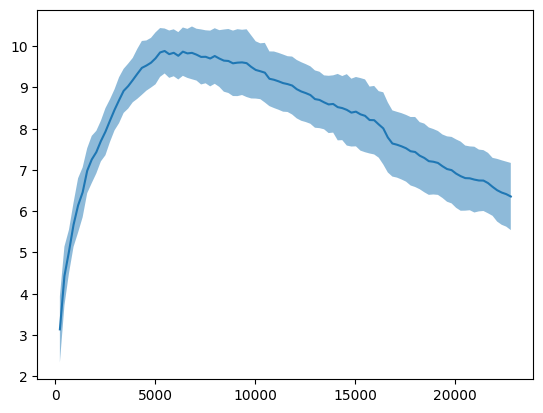

middle 16881


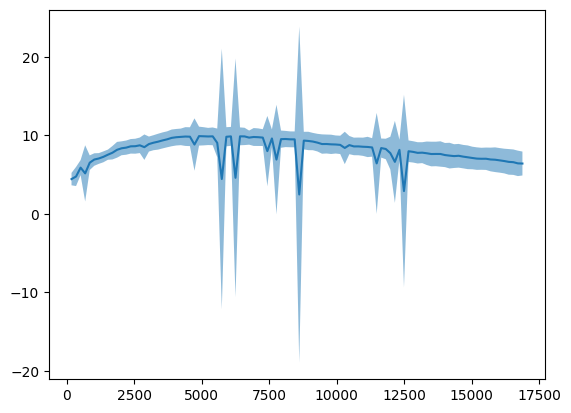

old 9858


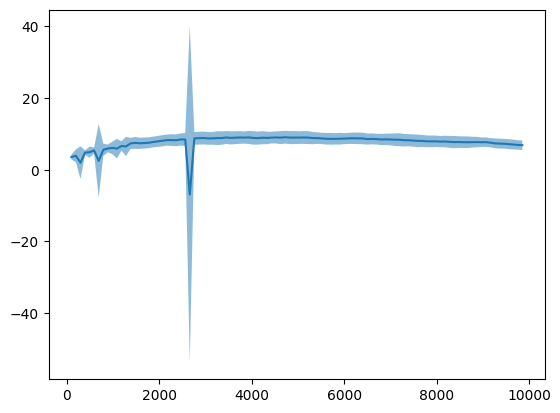

HighSchool&less 22584


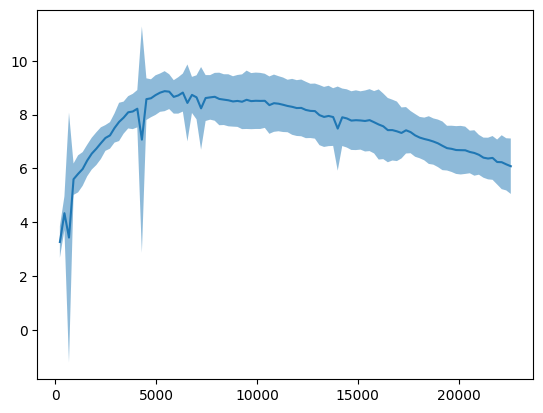

College&more 26947


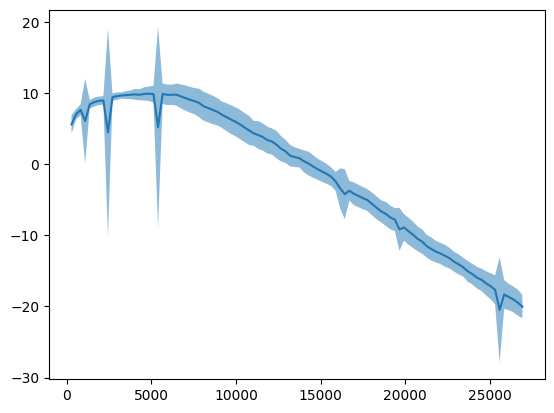

Male 33174


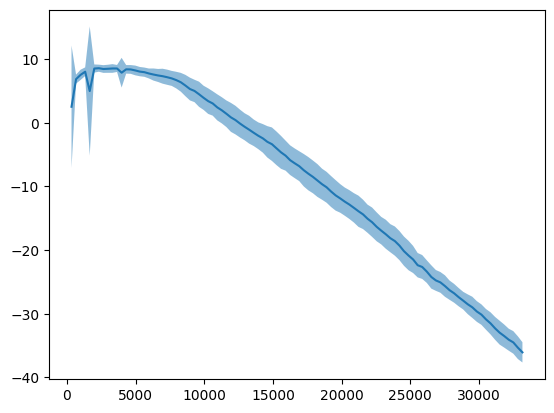

Female 16357


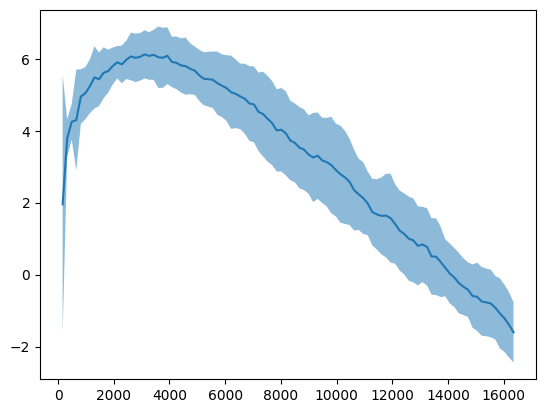

White 42441


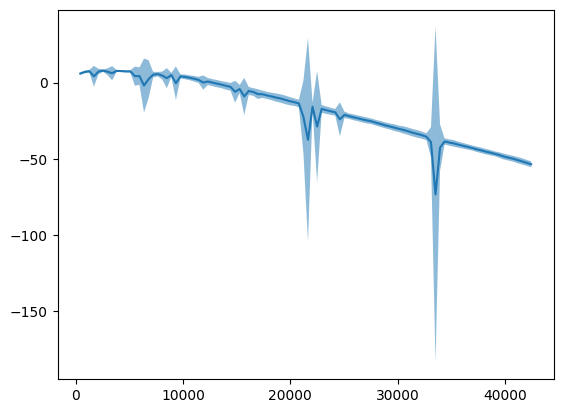

Asian-Pac-Islander 1519


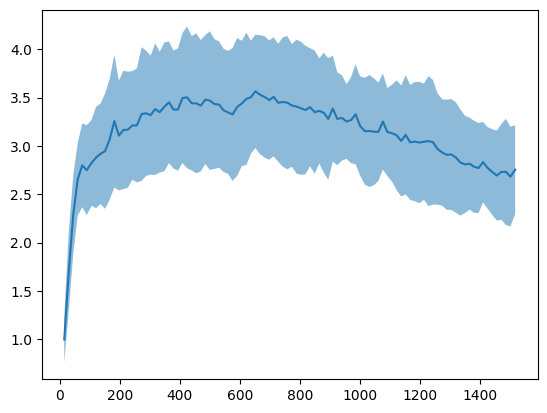

Amer-Indian-Eskimo 471


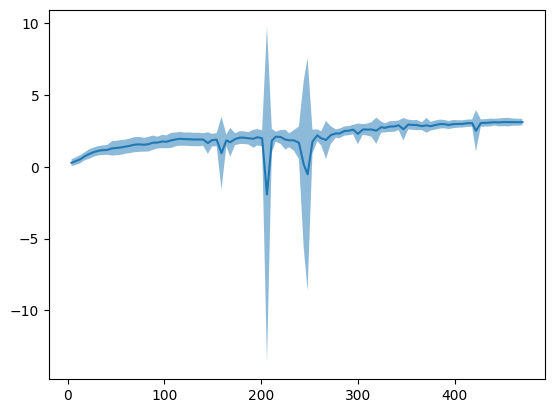

Other 406


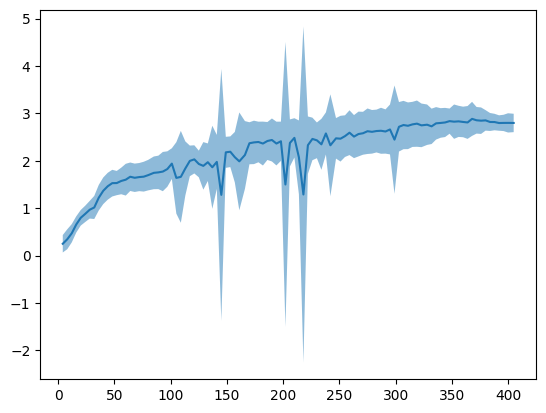

Black 4694


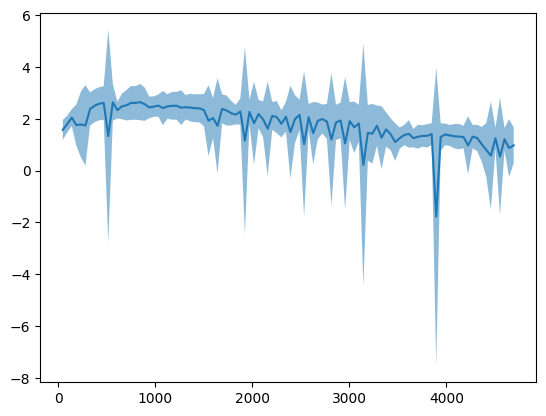

always_on 49531


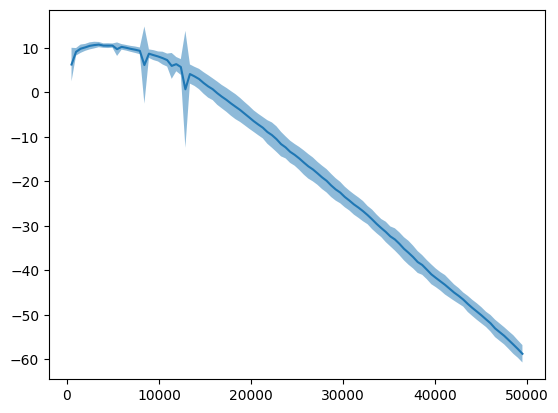

In [8]:
plot_ob.plot_regret_curve_with_std()